In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.transform.msdlm as transform_msdlm

import pathlib

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
def read_msd_lm_df(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    return df_msd_lm.loc[df_msd_lm["t/LJ"] > 1.0]

In [3]:
def get_ete_mean(path):
    df_ete = pd.read_csv(path)

    def calc_mean_R(df):
        R = 0
        for dim in ["x", "y", "z"]:
            R += (df[f"R_{dim}"] ** 2).mean()
        return R

    return df_ete.groupby("t").apply(calc_mean_R).rename("R^2")


N = 63
zeta = 1
b = .97
L_contour = N * b

experiments = [
    {
        "n": 17,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 6.02,
        "label": "EEA1-chain, $l_K/L=6.02$ "
    },
    {
        "n": 19,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 0.6,
        "label": "EEA1-chain, $l_K/L=0.6$ (bonded-like)"
    },
    {
        "n": 20,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 1 / N,
        "label": "Fully flexible chain"
    },
]

for experiment in experiments:
    print(f"Reading {experiment['path']}...")
    if experiment["n"] == 19 or experiment["n"] == 20:
        experiment["df_msdlm"] = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd_avg.csv")
    else:
        experiment["df_msdlm"] = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd.csv")
    experiment["df_ete_mean"] = get_ete_mean(experiment["path"] / "data" / "processed" / "ete.csv")

Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76...


3353.060740033601
1592.44146106041
58.80625


Text(0.02, 0.5, '$ETE/L$')

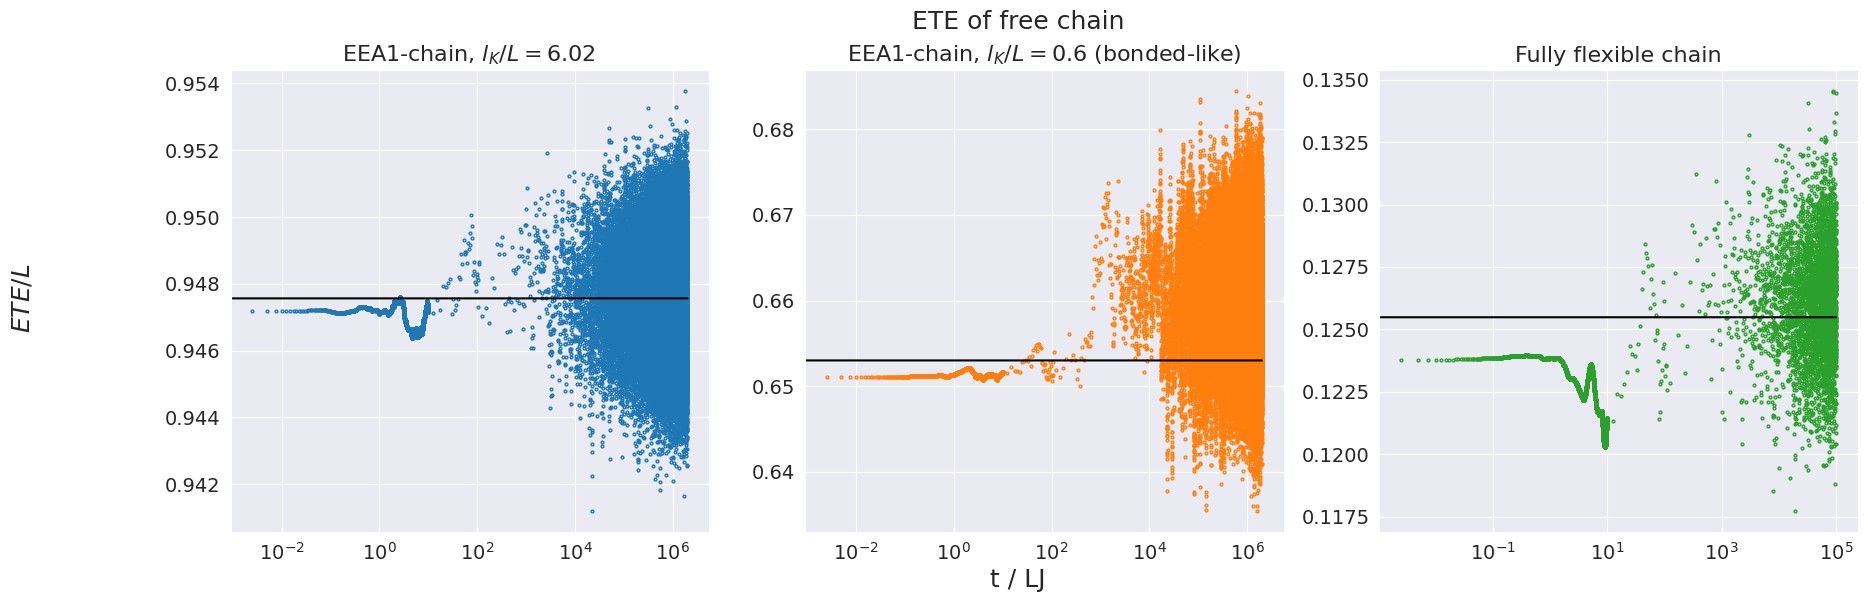

In [4]:
import matplotlib.patheffects as pe

fig, axs = plt.subplots(ncols=3, figsize=(21, 6))

for color, experiment, ax in zip(sns.color_palette(), experiments, axs):
    l_p = experiment["l_K"] * L_contour / 2
    R = 2 * l_p * L_contour - 2 * l_p ** 2 * (1 - np.exp(-L_contour / l_p))

    df = experiment["df_ete_mean"].copy()
    df.index = df.index * 0.0025
    df.index = df.index - df.index.min()

    print(R)

    marker_kwargs = {}
    marker_kwargs["linestyle"] = 'None'
    marker_kwargs["markersize"] = 2
    marker_kwargs["markerfacecolor"] = 'none'
    marker_kwargs["markeredgecolor"] = color
    marker_kwargs["fillstyle"] = 'none'
    marker_kwargs["marker"] = "o"
    ax.plot(df.index, np.sqrt(df) / L_contour, color=color, **marker_kwargs)

    ax.set(title=experiment["label"], xscale="log")

    ax.plot(
        df.index,
        np.repeat(np.sqrt(R) / L_contour, len(df)),
        color="black",
        label="ETE of worm like chain with corresponding $l_K$"
    )

fig.suptitle("ETE of free chain")
fig.supxlabel("t / LJ")
fig.supylabel("$ETE/L$")

In [5]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


df_rouse_msdlm = get_rouse_msdlm_df(experiments[0]["df_msdlm"]["t/LJ"])
df_rouse_msdlm

,t/LJ,dr_N^2
401,1.002500e+00,1.753697
402,1.005000e+00,1.756181
403,1.007500e+00,1.758662
404,1.010000e+00,1.761141
405,1.012500e+00,1.763616
...,...,...
84036,2.000000e+06,190495.757189
84037,2.000025e+06,190498.138141
84038,2.000050e+06,190500.519094
84039,2.000075e+06,190502.900046


Plotting 17 ...
Plotting 19 ...
Plotting 20 ...
Plotting 17 ...
Plotting 19 ...
Plotting 20 ...


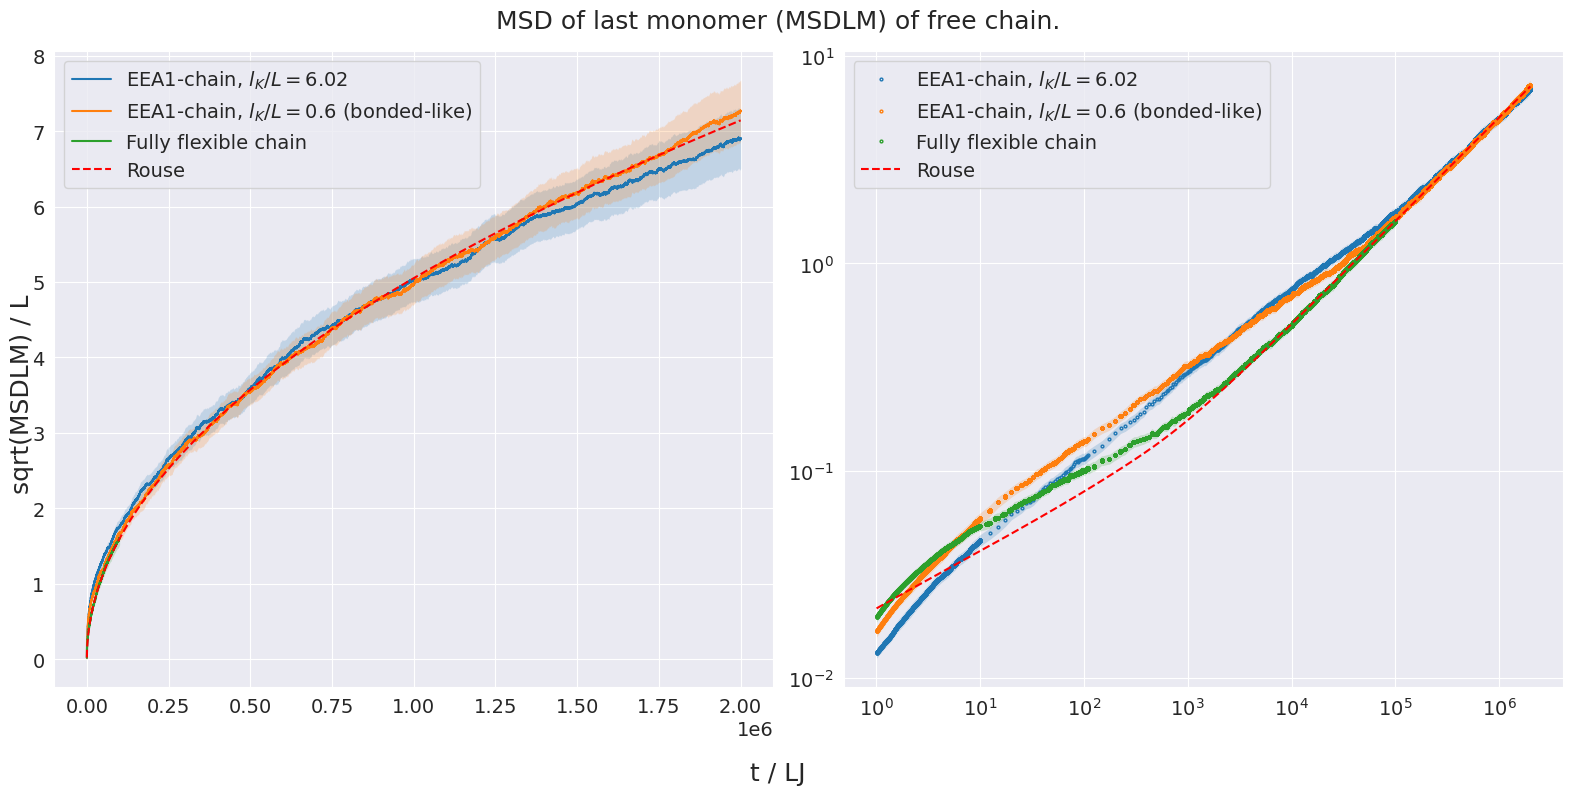

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, log in zip(axs, [False, True]):

    for experiment, color in zip(experiments, sns.color_palette()):
        
        print(f"Plotting {experiment['n']} ...")
        
        msd_plot.plot_MSD(
            experiment["df_msdlm"],
            log_scale=log,
            l_K=experiment["l_K"],
            L_contour=L_contour,
            zeta=zeta,
            zeta_e=experiment["zeta_e"],
            col="dr_N^2",
            label=experiment["label"],
            ax=ax,
            title="",
            ylabel="",
            xlabel="",
            scatter=log,
            marker_size=2,
            color=color
        )

    ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--", color="red")

    ax.legend()

fig.suptitle("MSD of last monomer (MSDLM) of free chain.")
fig.supylabel("sqrt(MSDLM) / L")
fig.supxlabel("t / LJ")
fig.tight_layout()

In [196]:
from scipy.optimize import curve_fit

def get_bins(df_msdlm: pd.DataFrame, th: float):
    i_max = len(df_msdlm["t/LJ"].index)
    bins = []
    
    for i in df_msdlm.index[1:]:
        t = df_msdlm["t/LJ"].iloc[i]
    
        j = i
        ts_bin = [t]
        while True:
            j += 1
            if j >= i_max:
                break
            t_j = df_msdlm["t/LJ"].iloc[j]
            if np.abs(np.log10(t_j/t)) < th:
                ts_bin.append(t_j)
            else:
                break
    
        j = i
        while True:
            j -= 1
            if j <= 0:
                break
            t_j = df_msdlm["t/LJ"].iloc[j]
            if np.abs(np.log10(t_j/t)) < th:
                ts_bin.append(t_j)
            else:
                break
        
        ts_bin = sorted(ts_bin)
        
        bins.append((ts_bin[0], ts_bin[-1]))

    return bins




In [14]:
n_bins = 12

for experiment in experiments:
    experiment["alpha"] = transform_msdlm.calculate_msd_alpha_df(experiment["df_msdlm"], n_bins=n_bins)

alpha_rouse = transform_msdlm.calculate_msd_alpha_df(df_rouse_msdlm, n_bins)

experiments[0]["alpha"]

,alpha,delta alpha
t/LJ,,
1.00499,1.217623,0.004463
3.75657,0.927727,0.004071
14.04165,0.823889,0.038964
52.48606,0.779821,0.042115
196.18687,0.819333,0.029749
733.32401,0.809612,0.015793
2741.08100,0.807300,0.007179
10245.84633,0.735575,0.003633
38297.79815,0.775778,0.001915


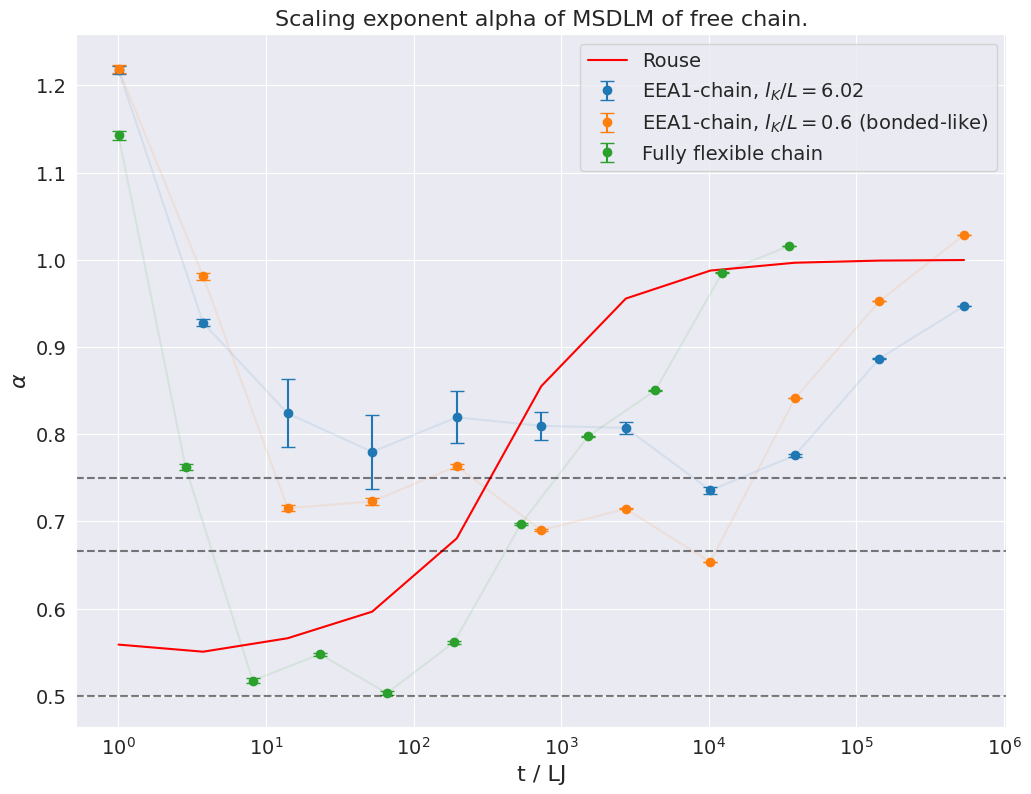

In [15]:
from scipy.signal import savgol_filter

ax: plt.Axes
fig, ax = plt.subplots()

for color, experiment in zip(sns.color_palette(), experiments):
    ax.errorbar(
        experiment["alpha"].index, 
        y=experiment["alpha"]["alpha"], 
        yerr=experiment["alpha"]["delta alpha"], 
        label=experiment["label"], 
        color=color,
        marker = "o",
        linestyle="none",
        capsize=5
    )
    ax.plot(experiment["alpha"].index, experiment["alpha"]["alpha"], color=color, alpha=0.1)

ax.plot(alpha_rouse.index, alpha_rouse["alpha"], linestyle="-", label="Rouse", color="red")

ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.5)
ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.5)
ax.axhline(y=1 / 2, color="black", linestyle="--", alpha=0.5)

ax.set(xscale="log", xlabel="t / LJ", ylabel="$\\alpha$", title="Scaling exponent alpha of MSDLM of free chain.")
ax.legend()